# More Seals ML

<h3 style="color:green">(apologies for the chaotic brain dump)</h3>

## Prerequisites
- Download DAY1-DAY5 raw .edf files and 1Hz hypnogram .csv files for Wednesday, Ashley, Bertha, Juliette, Heidi
    - Put raw edf files in data/raw/01_edf_data
    - Put hypnogram csv files in data/raw/02_hypnogram_data
    - Create a config.json file for each seal with desired channel configuration
- Wednesday:<br>
`python src/features/feature_generation.py -i data/raw/01_edf_data -o data/processed -t True -s test12_Wednesday -l data/raw/02_hypnogram_data/test12_Wednesday_06_Hypnogram_JKB_1Hz.csv -c data/raw/config/Wednesday_config.json`
<br>

- Heidi:<br>
`python src/features/feature_generation.py -i data/raw/01_edf_data -o data/processed -t True -s test33_HypoactiveHeidi -l data/raw/02_hypnogram_data/test33_HypoactiveHeidi_06_Hypnogram_JKB_1Hz.csv -c data/raw/config/HypoactiveHeidi_config.json`
<br>

- Ashley:<br>
`python src/features/feature_generation.py -i data/raw/01_edf_data -o data/processed -t True -s test23_AshyAshley -l data/raw/02_hypnogram_data/test23_AshyAshley_06_Hypnogram_JKB_1Hz.csv -c data/raw/config/AshyAshley_config.json`
<br>

- Bertha:<br>
`python src/features/feature_generation.py -i data/raw/01_edf_data -o data/processed -t True -s test24_BerthaBeauty -l data/raw/02_hypnogram_data/test24_BerthaBeauty_06_Hypnogram_JKB_1Hz.csv -c data/raw/config/BerthaBeauty_config.json`
<br>

- Suzy:<br>
`python src/features/feature_generation.py -i data/raw/01_edf_data -o data/processed -t True -s test20_SnoozySuzy -l data/raw/02_hypnogram_data/test20_SnoozySuzy_06_Hypnogram_JKB_1Hz.csv -c data/raw/config/SnoozySuzy_config.json`
<br>

- Juliette:<br>
`python src/features/feature_generation.py -i data/raw/01_edf_data -o data/processed -t True -s test35_JauntingJuliette -l data/raw/02_hypnogram_data/test35_JauntingJuliette_06_Hypnogram_JKB_1Hz.csv -c data/raw/config/JauntingJuliette_config.json`
<br>

# Table of Contents
## [Feature Distribution Plots](#feature_distribution_plots)
## [Wednesday refined model on each seal](#wednesday_on_each)
## Each seal on itself
## Other seals + how much to make this one accurate

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.insert(0, '..')

In [3]:
import src.features.feature_generation as seal_fgen
import src.features.feature_generation_utils as seal_fe
import src.models.build_model_LGBM as seal_model
import src.visualization.visualize as seal_viz

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import mne
import os
import pyedflib
import pytz
import re
import datetime
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from lightgbm import LGBMClassifier

pst_timezone = pytz.timezone('America/Los_Angeles')

In [5]:
def load_dfs_from_dir(folder, filename):
    features_dfs = []
    for file in os.listdir(folder):
        if filename in file:
            print(file)
            try:
                setting_string = re.findall('EE_[0-9]+_EW_[0-9]+_HE_[0-9]+_HW_[0-9]+', file)[0]
                eeg_epoch_setting = re.findall('EE_[0-9]+', setting_string)[0][3:]
                eeg_welch_setting = re.findall('EW_[0-9]+', setting_string)[0][3:]
                heartrate_epoch_setting = re.findall('HE_[0-9]+', setting_string)[0][3:]
                heartrate_welch_setting = re.findall('HW_[0-9]+', setting_string)[0][3:]
                eeg_setting_string = f'EPOCH_{eeg_epoch_setting}_WELCH_{eeg_welch_setting}'
                heartrate_setting_string = f'EPOCH_{heartrate_epoch_setting}_WELCH_{heartrate_welch_setting}'
            except:
                raise Exception(f'File {file} does not have EE_##_EW_##_HE_##_HW_## in filename')
            features_df = pd.read_csv(os.path.join(folder, file), index_col=0)
            features_df.index = pd.DatetimeIndex(features_df.index, tz=pst_timezone)
            new_cols = []
            for column in features_df.columns:
                if 'yasa_eeg' in column:
                    new_cols.append(eeg_setting_string + '_' + column)
                elif 'yasa_heartrate' in column:
                    new_cols.append(heartrate_setting_string + '_' + column)
                else:
                    new_cols.append(column)
            features_df.columns = new_cols
            features_dfs.append(features_df)
    features_dfs = pd.concat(features_dfs, axis=1)
    features_dfs = features_dfs.loc[:,~features_dfs.columns.duplicated()].copy()
    return features_dfs

In [10]:
wednesday_df = load_dfs_from_dir('../data/processed/test12_Wednesday', 'test12_Wednesday')
heidi_df = load_dfs_from_dir('../data/processed/test33_HypoactiveHeidi', 'test33_HypoactiveHeidi')
ashley_df = load_dfs_from_dir('../data/processed/test23_AshyAshley', 'test23_AshyAshley')
bertha_df = load_dfs_from_dir('../data/processed/test24_BerthaBeauty', 'test24_BerthaBeauty')
suzy_df = load_dfs_from_dir('../data/processed/test20_SnoozySuzy', 'test20_SnoozySuzy')
juliette_df = load_dfs_from_dir('../data/processed/test35_JauntingJuliette', 'test35_JauntingJuliette')

test12_Wednesday_07_features_with_labels_EE_64_EW_4_HE_512_HW_256.csv
test12_Wednesday_07_features_with_labels_EE_128_EW_1_HE_512_HW_512.csv
test12_Wednesday_07_features_with_labels_EE_32_EW_1_HE_512_HW_64.csv
test12_Wednesday_07_features_with_labels_EE_128_EW_4_HE_256_HW_256.csv
test12_Wednesday_07_features_with_labels_EE_128_EW_16_HE_256_HW_64.csv
test33_HypoactiveHeidi_07_features_with_labels_EE_128_EW_1_HE_512_HW_512.csv
test33_HypoactiveHeidi_07_features_with_labels_EE_64_EW_4_HE_512_HW_256.csv
test33_HypoactiveHeidi_07_features_with_labels_EE_128_EW_16_HE_256_HW_64.csv
test33_HypoactiveHeidi_07_features_with_labels_EE_128_EW_4_HE_256_HW_256.csv
test33_HypoactiveHeidi_07_features_with_labels_EE_32_EW_1_HE_512_HW_64.csv
test23_AshyAshley_07_features_with_labels_EE_64_EW_4_HE_512_HW_256.csv
test23_AshyAshley_07_features_with_labels_EE_128_EW_1_HE_512_HW_512.csv
test23_AshyAshley_07_features_with_labels_EE_128_EW_4_HE_256_HW_256.csv
test23_AshyAshley_07_features_with_labels_EE_32_EW_

<a id='feature_distribution_plots'></a>
## Feature distribution plots

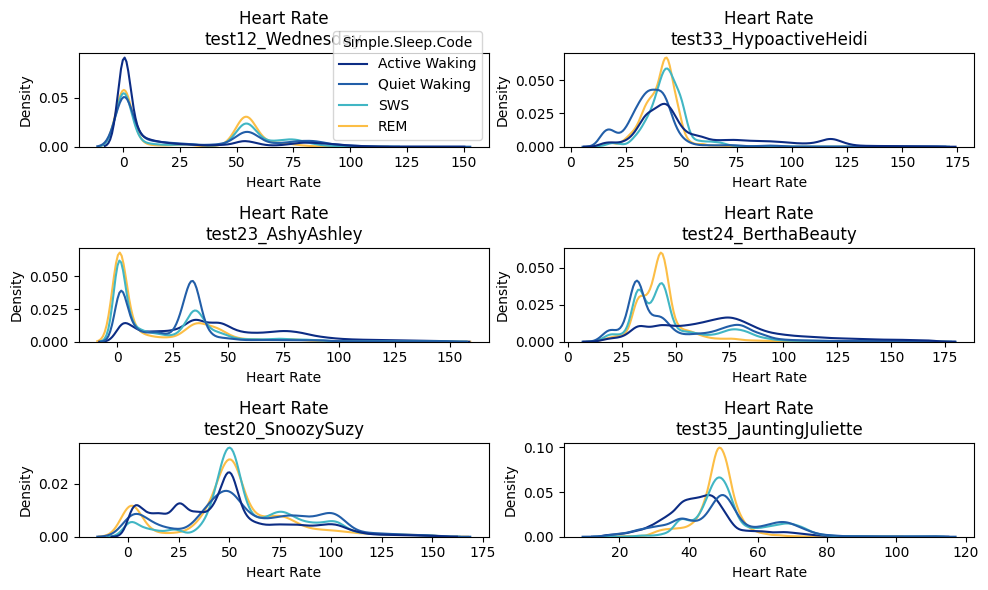

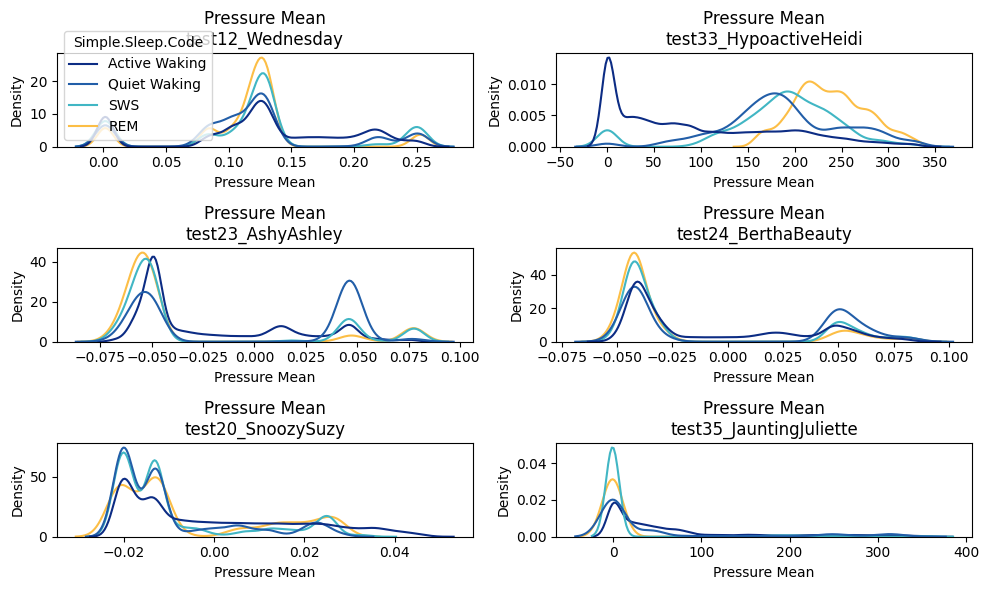

In [ ]:
seal_names = ['test12_Wednesday', 'test33_HypoactiveHeidi', 'test23_AshyAshley', 'test24_BerthaBeauty',
              'test20_SnoozySuzy', 'test35_JauntingJuliette']
for col in ['Heart Rate', 'Pressure Mean', 'Pressure Std.Dev', 'GyrZ Std.Dev', 'yasa_eeg_std',
       'yasa_eeg_sdelta', 'yasa_eeg_fdelta', 'yasa_eeg_dt',
       'yasa_eeg_ds', 'yasa_eeg_db', 'yasa_eeg_abspow']:
    if 'yasa_eeg' in col:
        for eeg_setting in [
            'EPOCH_128_WELCH_16',
            'EPOCH_64_WELCH_4'
        ]:
            try:
                eeg_col = eeg_setting + '_' + col
                fig, axs = plt.subplots(3, 2, figsize=(10, 6))
                for i, seal_df in enumerate([wednesday_df, heidi_df, ashley_df, bertha_df, suzy_df, juliette_df]):
                    i1, i2 = i // 2, i % 2
                    seal_viz.plot_feature_density(seal_df[~seal_df['Simple.Sleep.Code'].isin(['Unscorable', 'Drowsiness'])],
                                                  eeg_col, 'Simple.Sleep.Code',
                                                  title=eeg_col + '\n' + seal_names[i],
                                                  ax=axs[i1][i2])
                    if i1 != 0 or i2 != 0:
                        axs[i1][i2].get_legend().remove()
                fig.tight_layout()
                fig.savefig(f'../data/interim/more_seals_figs/{eeg_col.replace(" ", "_")}.png', bbox_inches='tight')
                plt.show()
                print('\n'*5)
            except:
                print(col, eeg_setting)
                
    else:
        fig, axs = plt.subplots(3, 2, figsize=(10, 6))
        for i, seal_df in enumerate([wednesday_df, heidi_df, ashley_df, bertha_df, suzy_df, juliette_df]):
            i1, i2 = i // 2, i % 2
            try:
                if 'Pressure' in col and col not in seal_df.columns:
                    print('here')
                    new_col = col.replace('Pressure', 'Depth')
                    seal_viz.plot_feature_density(seal_df[~seal_df['Simple.Sleep.Code'].isin(['Unscorable', 'Drowsiness'])],
                                                  new_col, 'Simple.Sleep.Code',
                                                  title=new_col + '\n' + seal_names[i],
                                                  ax=axs[i1][i2])
                else:
                    if 'Pressure' in col or 'Depth' in col:
                        seal_viz.plot_feature_density(seal_df[~seal_df['Simple.Sleep.Code'].isin(['Unscorable', 'Drowsiness'])],
                                                      col, 'Simple.Sleep.Code',
                                                      title=col + '\n' + seal_names[i],
                                                      ax=axs[i1][i2])
                    else:
                        seal_viz.plot_feature_density(seal_df[~seal_df['Simple.Sleep.Code'].isin(['Unscorable', 'Drowsiness'])],
                                                      col, 'Simple.Sleep.Code',
                                                      title=col + '\n' + seal_names[i],
                                                      ax=axs[i1][i2])
                if i1 != 0 or i2 != 0:
                    axs[i1][i2].get_legend().remove()
            except:
                print(col, seal_names[i])
        fig.savefig(f'../data/interim/more_seals_figs/{col.replace(" ", "_")}.png', bbox_inches='tight')
        fig.tight_layout()
        plt.show()
        print('\n'*5)

<a id='wednesday_on_each'></a>
# Wednesday refined model on each seal

In [14]:
wednesday_df = load_dfs_from_dir('../data/processed/test12_Wednesday', 'test12_Wednesday')
heidi_df = load_dfs_from_dir('../data/processed/test33_HypoactiveHeidi', 'test33_HypoactiveHeidi')
ashley_df = load_dfs_from_dir('../data/processed/test23_AshyAshley', 'test23_AshyAshley')
bertha_df = load_dfs_from_dir('../data/processed/test24_BerthaBeauty', 'test24_BerthaBeauty')
suzy_df = load_dfs_from_dir('../data/processed/test20_SnoozySuzy', 'test20_SnoozySuzy')
juliette_df = load_dfs_from_dir('../data/processed/test35_JauntingJuliette', 'test35_JauntingJuliette')

test12_Wednesday_07_features_with_labels_EE_64_EW_4_HE_512_HW_256.csv
test12_Wednesday_07_features_with_labels_EE_128_EW_1_HE_512_HW_512.csv
test12_Wednesday_07_features_with_labels_EE_32_EW_1_HE_512_HW_64.csv
test12_Wednesday_07_features_with_labels_EE_128_EW_4_HE_256_HW_256.csv
test12_Wednesday_07_features_with_labels_EE_128_EW_16_HE_256_HW_64.csv
test33_HypoactiveHeidi_07_features_with_labels_EE_128_EW_1_HE_512_HW_512.csv
test33_HypoactiveHeidi_07_features_with_labels_EE_64_EW_4_HE_512_HW_256.csv
test33_HypoactiveHeidi_07_features_with_labels_EE_128_EW_16_HE_256_HW_64.csv
test33_HypoactiveHeidi_07_features_with_labels_EE_128_EW_4_HE_256_HW_256.csv
test33_HypoactiveHeidi_07_features_with_labels_EE_32_EW_1_HE_512_HW_64.csv
test23_AshyAshley_07_features_with_labels_EE_64_EW_4_HE_512_HW_256.csv
test23_AshyAshley_07_features_with_labels_EE_128_EW_1_HE_512_HW_512.csv
test23_AshyAshley_07_features_with_labels_EE_128_EW_4_HE_256_HW_256.csv
test23_AshyAshley_07_features_with_labels_EE_32_EW_

In [15]:
# Drop ODBA Mean and Std.Dev because not all the seals have it
wednesday_df = wednesday_df.drop('ODBA Mean', axis=1)
wednesday_df = wednesday_df.drop('ODBA Std.Dev', axis=1)
def filter_cols_to_wednesdays(seal_df, seal_name):
    if 'ODBA Mean' in seal_df.columns:
        seal_df = seal_df.drop('ODBA Mean', axis=1)
    if 'ODBA Std.Dev' in seal_df.columns:
        seal_df = seal_df.drop('ODBA Std.Dev', axis=1)
    print(seal_name, 'has same columns as Wednesday:', set(wednesday_df.columns) == set(seal_df.columns))
    print('Columns not in Wednesday:', [col for col in wednesday_df.columns if col not in seal_df.columns])
    print(f'Columns not in {seal_name}:', [col for col in seal_df.columns if col not in wednesday_df.columns])
    return seal_df
heidi_df = filter_cols_to_wednesdays(heidi_df, 'HypoactiveHeidi')
ashley_df = filter_cols_to_wednesdays(ashley_df, 'AshyAshley')
bertha_df = filter_cols_to_wednesdays(bertha_df, 'BerthaBeauty')
suzy_df = filter_cols_to_wednesdays(suzy_df, 'SnoozySuzy')
juliette_df = filter_cols_to_wednesdays(juliette_df, 'JauntingJuliette')

HypoactiveHeidi has same columns as Wednesday: True
Columns not in Wednesday: []
Columns not in HypoactiveHeidi: []
AshyAshley has same columns as Wednesday: True
Columns not in Wednesday: []
Columns not in AshyAshley: []
BerthaBeauty has same columns as Wednesday: True
Columns not in Wednesday: []
Columns not in BerthaBeauty: []
SnoozySuzy has same columns as Wednesday: True
Columns not in Wednesday: []
Columns not in SnoozySuzy: []
JauntingJuliette has same columns as Wednesday: True
Columns not in Wednesday: []
Columns not in JauntingJuliette: []


### Train model on Wednesday

In [18]:
wednesday_train_data['Simple.Sleep.Code'].value_counts()

Simple.Sleep.Code
Active Waking    106773
SWS               39889
Quiet Waking      32417
REM               25068
Drowsiness        22164
Unscorable         6221
Name: count, dtype: int64

In [17]:
wednesday_train_data = wednesday_df.dropna()
X_train, y_train = wednesday_train_data.drop('Simple.Sleep.Code', axis=1), wednesday_train_data['Simple.Sleep.Code']
wednesday_only_model = LGBMClassifier(**{'learning_rate': 0.005, 'n_estimators': 400, 'num_leaves': 10})
wednesday_only_model.fit(X_train, y_train)
print('-'*20)
print('5-fold validated training accuracy')
print('-'*20)
fold_accs, class_accs, _, conf_matr = seal_model.evaluate_model(wednesday_train_data, 'Simple.Sleep.Code',
                                                                verbosity=-1)
print("Overall accuracy: ", round(np.mean(fold_accs) * 100, 2), '%', sep='')
print()
print("Mean class accuracies across folds:")
print(class_accs)
print()
print('Overall confusion matrix:')
conf_matr

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034072 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 58623
[LightGBM] [Info] Number of data points in the train set: 232532, number of used features: 249
[LightGBM] [Info] Start training from score -0.778323
[LightGBM] [Info] Start training from score -2.350558
[LightGBM] [Info] Start training from score -1.970345
[LightGBM] [Info] Start training from score -2.227436
[LightGBM] [Info] Start training from score -1.762927
[LightGBM] [Info] Start training from score -3.621097
--------------------
5-fold validated training accuracy
--------------------
Overall accuracy: 78.76%

Mean class accuracies across folds:
Active Waking    92.87
Drowsiness       63.74
Quiet Waking     46.09
REM              69.46
SWS      

,Predicted_Active_Waking,Predicted_Quiet_Waking,Predicted_Drowsiness,Predicted_SWS,Predicted_REM,Predicted_Unscorable
True_Active_Waking,99781,4219,1182,1313,278,0
True_Quiet_Waking,10027,15668,3189,930,2603,0
True_Drowsiness,2095,4175,14242,1519,133,0
True_SWS,3459,1732,1542,32671,485,0
True_REM,366,3269,80,572,20781,0
True_Unscorable,6145,56,8,12,0,0


### HypoactiveHeidi

In [20]:
heidi_test_data['Simple.Sleep.Code'].value_counts()

Simple.Sleep.Code
Active Waking    392883
SWS                8984
Quiet Waking       5351
REM                4660
Name: count, dtype: int64

In [19]:
print(len(heidi_df))
heidi_test_data = heidi_df.dropna()
heidi_test_data = heidi_test_data[heidi_test_data['Simple.Sleep.Code'] != 'Unscorable']
print(len(heidi_test_data))

fold_accs, class_accs, _, conf_matr = seal_model.evaluate_model(heidi_test_data, 'Simple.Sleep.Code',
                                                             model=wednesday_only_model, verbosity=-1)
print("Overall accuracy: ", round(np.mean(fold_accs) * 100, 2), '%', sep='')
print()
print("Mean class accuracies across folds:")
print(class_accs)
print()
print('Overall confusion matrix:')
conf_matr

411922
411878
Overall accuracy: 94.23%

Mean class accuracies across folds:
Active Waking    97.89
Quiet Waking      0.47
REM              26.02
SWS              28.26
dtype: float64

Overall confusion matrix:


,Predicted_Active_Waking,Predicted_Quiet_Waking,Predicted_SWS,Predicted_REM
True_Active_Waking,384678,71,8085,0
True_Quiet_Waking,5074,29,173,66
True_SWS,5693,24,2591,58
True_REM,3656,68,128,808


### AshyAshley

In [22]:
ashley_test_data['Simple.Sleep.Code'].value_counts()

Simple.Sleep.Code
Active Waking    192363
SWS               93518
Quiet Waking      50904
REM               32868
Drowsiness        26195
Name: count, dtype: int64

In [21]:
print(len(ashley_df))
ashley_test_data = ashley_df.dropna()
ashley_test_data = ashley_test_data[ashley_test_data['Simple.Sleep.Code'] != 'Unscorable']
print(len(ashley_test_data))

fold_accs, class_accs, _, conf_matr = seal_model.evaluate_model(ashley_test_data, 'Simple.Sleep.Code',
                                                                model=wednesday_only_model, verbosity=-1)
print("Overall accuracy: ", round(np.mean(fold_accs) * 100, 2), '%', sep='')
print()
print("Mean class accuracies across folds:")
print(class_accs)
print()
print('Overall confusion matrix:')
conf_matr

420648
395848
Overall accuracy: 60.33%

Mean class accuracies across folds:
Active Waking    88.75
Drowsiness       14.04
Quiet Waking     15.59
REM              60.43
SWS              27.11
dtype: float64

Overall confusion matrix:


,Predicted_Active_Waking,Predicted_Quiet_Waking,Predicted_Drowsiness,Predicted_SWS,Predicted_REM
True_Active_Waking,179031,9415,71,1933,1913
True_Quiet_Waking,23298,8064,124,612,18806
True_Drowsiness,1638,8568,96,690,15203
True_SWS,28966,11878,4545,27243,20886
True_REM,5418,2074,570,444,24362


### BerthaBeauty

In [24]:
bertha_test_data['Simple.Sleep.Code'].value_counts()

Simple.Sleep.Code
Active Waking    185773
SWS              103764
Quiet Waking      59091
REM               40078
Drowsiness        23673
Name: count, dtype: int64

In [23]:
print(len(bertha_df))
bertha_test_data = bertha_df.dropna()
bertha_test_data = bertha_test_data[bertha_test_data['Simple.Sleep.Code'] != 'Unscorable']
print(len(bertha_test_data))

fold_accs, class_accs, _, conf_matr = seal_model.evaluate_model(bertha_test_data, 'Simple.Sleep.Code',
                                                                model=wednesday_only_model, verbosity=-1)
print("Overall accuracy: ", round(np.mean(fold_accs) * 100, 2), '%', sep='')
print()
print("Mean class accuracies across folds:")
print(class_accs)
print()
print('Overall confusion matrix:')
conf_matr

417083
412379
Overall accuracy: 42.8%

Mean class accuracies across folds:
Active Waking    63.91
Drowsiness        0.00
Quiet Waking     25.23
REM              66.97
SWS               7.77
dtype: float64

Overall confusion matrix:


,Predicted_Active_Waking,Predicted_Quiet_Waking,Predicted_Drowsiness,Predicted_SWS,Predicted_REM
True_Active_Waking,127517,20544,142,1479,36085
True_Quiet_Waking,6464,13676,27,610,38314
True_Drowsiness,1013,5903,3,498,16256
True_SWS,12450,21594,994,8180,60546
True_REM,2883,9262,327,476,27130


### SnoozySuzy

In [26]:
suzy_test_data['Simple.Sleep.Code'].value_counts(normalize=False)

Simple.Sleep.Code
Active Waking    165681
SWS               34972
Quiet Waking      11438
REM                8886
Name: count, dtype: int64

In [25]:
print(len(suzy_df))
suzy_test_data = suzy_df.dropna()
suzy_test_data = suzy_test_data[suzy_test_data['Simple.Sleep.Code'] != 'Unscorable']
print(len(suzy_test_data))

fold_accs, class_accs, _, conf_matr = seal_model.evaluate_model(suzy_test_data, 'Simple.Sleep.Code',
                                                                model=wednesday_only_model, verbosity=-1)
print("Overall accuracy: ", round(np.mean(fold_accs) * 100, 2), '%', sep='')
print()
print("Mean class accuracies across folds:")
print(class_accs)
print()
print('Overall confusion matrix:')
conf_matr

265715
220977
Overall accuracy: 77.95%

Mean class accuracies across folds:
Active Waking    97.92
Quiet Waking      5.41
REM              38.86
SWS              13.87
dtype: float64

Overall confusion matrix:


,Predicted_Active_Waking,Predicted_Quiet_Waking,Predicted_SWS,Predicted_REM
True_Active_Waking,162478,1477,473,1253
True_Quiet_Waking,7985,494,181,2778
True_SWS,23783,1375,4943,4782
True_REM,4367,152,28,4339


### JauntingJuliette

In [28]:
juliette_test_data['Simple.Sleep.Code'].value_counts(normalize=False)

Simple.Sleep.Code
Active Waking    228570
SWS               25094
Quiet Waking      14889
REM                8520
Drowsiness          596
Name: count, dtype: int64

In [27]:
print(len(juliette_df))
juliette_test_data = juliette_df.dropna()
juliette_test_data = juliette_test_data[juliette_test_data['Simple.Sleep.Code'] != 'Unscorable']
print(len(juliette_test_data))

fold_accs, class_accs, _, conf_matr = seal_model.evaluate_model(juliette_test_data, 'Simple.Sleep.Code',
                                                                model=wednesday_only_model, verbosity=-1)
print("Overall accuracy: ", round(np.mean(fold_accs) * 100, 2), '%', sep='')
print()
print("Mean class accuracies across folds:")
print(class_accs)
print()
print('Overall confusion matrix:')
conf_matr

311104
277669
Overall accuracy: 61.32%

Mean class accuracies across folds:
Active Waking    70.75
Quiet Waking      4.73
SWS              30.12
REM              38.26
Drowsiness       14.43
dtype: float64

Overall confusion matrix:


,Predicted_Active_Waking,Predicted_Quiet_Waking,Predicted_Drowsiness,Predicted_SWS,Predicted_REM
True_Active_Waking,154727,12890,44,24643,36266
True_Quiet_Waking,9272,1073,85,2163,2296
True_Drowsiness,31,0,86,216,263
True_SWS,8129,869,3394,11241,1461
True_REM,1243,2604,429,1117,3127


# Each seal trained on itself (cross-validation score)

### HypoactiveHeidi

In [29]:
heidi_train_data = heidi_df.dropna()
X_train, y_train = heidi_train_data.drop('Simple.Sleep.Code', axis=1), heidi_train_data['Simple.Sleep.Code']
heidi_only_model = LGBMClassifier(**{'learning_rate': 0.005, 'n_estimators': 400, 'num_leaves': 10})
heidi_only_model.fit(X_train, y_train)
print('-'*20)
print('5-fold validated training accuracy')
print('-'*20)
fold_accs, class_accs, _, conf_matr = seal_model.evaluate_model(heidi_train_data, 'Simple.Sleep.Code',
                                                                verbosity=-1)
print("Overall accuracy: ", round(np.mean(fold_accs) * 100, 2), '%', sep='')
print()
print("Mean class accuracies across folds:")
print(class_accs)
print()
print('Overall confusion matrix:')
conf_matr

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.042957 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 59603
[LightGBM] [Info] Number of data points in the train set: 411878, number of used features: 249
[LightGBM] [Info] Start training from score -0.047215
[LightGBM] [Info] Start training from score -4.343444
[LightGBM] [Info] Start training from score -4.481712
[LightGBM] [Info] Start training from score -3.825282
--------------------
5-fold validated training accuracy
--------------------
Overall accuracy: 97.33%

Mean class accuracies across folds:
Active Waking    99.47
Quiet Waking     42.10
REM              68.37
SWS              58.49
dtype: float64

Overall confusion matrix:


,Predicted_Active_Waking,Predicted_Quiet_Waking,Predicted_SWS,Predicted_REM
True_Active_Waking,390778,761,1324,20
True_Quiet_Waking,3308,1688,355,0
True_SWS,2886,429,5458,211
True_REM,1420,4,279,2957


### AshyAshley

In [30]:
ashley_train_data = ashley_df.dropna()
X_train, y_train = ashley_train_data.drop('Simple.Sleep.Code', axis=1), ashley_train_data['Simple.Sleep.Code']
ashley_only_model = LGBMClassifier(**{'learning_rate': 0.005, 'n_estimators': 400, 'num_leaves': 10})
ashley_only_model.fit(X_train, y_train)
print('-'*20)
print('5-fold validated training accuracy')
print('-'*20)
fold_accs, class_accs, _, conf_matr = seal_model.evaluate_model(ashley_train_data, 'Simple.Sleep.Code',
                                                                verbosity=-1)
print("Overall accuracy: ", round(np.mean(fold_accs) * 100, 2), '%', sep='')
print()
print("Mean class accuracies across folds:")
print(class_accs)
print()
print('Overall confusion matrix:')
conf_matr

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.054639 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 59659
[LightGBM] [Info] Number of data points in the train set: 416951, number of used features: 249
[LightGBM] [Info] Start training from score -0.773584
[LightGBM] [Info] Start training from score -2.767400
[LightGBM] [Info] Start training from score -2.103027
[LightGBM] [Info] Start training from score -2.540469
[LightGBM] [Info] Start training from score -1.494815
[LightGBM] [Info] Start training from score -2.983553
--------------------
5-fold validated training accuracy
--------------------
Overall accuracy: 71.57%

Mean class accuracies across folds:
Active Waking    91.25
Drowsiness       39.91
Quiet Waking     48.84
REM              43.07
SWS      

,Predicted_Active_Waking,Predicted_Quiet_Waking,Predicted_Drowsiness,Predicted_SWS,Predicted_REM,Predicted_Unscorable
True_Active_Waking,177655,6909,408,7258,133,0
True_Quiet_Waking,9288,25395,2880,11296,2045,0
True_Drowsiness,2609,9548,5324,7098,1616,0
True_SWS,11136,7595,1613,71063,2111,0
True_REM,849,3142,225,9658,18994,0
True_Unscorable,17751,15,239,2888,210,0


### BerthaBeauty

In [31]:
bertha_train_data = bertha_df.dropna()
X_train, y_train = bertha_train_data.drop('Simple.Sleep.Code', axis=1), bertha_train_data['Simple.Sleep.Code']
bertha_only_model = LGBMClassifier(**{'learning_rate': 0.005, 'n_estimators': 400, 'num_leaves': 10})
bertha_only_model.fit(X_train, y_train)
print('-'*20)
print('5-fold validated training accuracy')
print('-'*20)
fold_accs, class_accs, _, conf_matr = seal_model.evaluate_model(bertha_train_data, 'Simple.Sleep.Code',
                                                                verbosity=-1)
print("Overall accuracy: ", round(np.mean(fold_accs) * 100, 2), '%', sep='')
print()
print("Mean class accuracies across folds:")
print(class_accs)
print()
print('Overall confusion matrix:')
conf_matr

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.049077 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 59631
[LightGBM] [Info] Number of data points in the train set: 417014, number of used features: 249
[LightGBM] [Info] Start training from score -0.808594
[LightGBM] [Info] Start training from score -2.868785
[LightGBM] [Info] Start training from score -1.954041
[LightGBM] [Info] Start training from score -2.342292
[LightGBM] [Info] Start training from score -1.391001
[LightGBM] [Info] Start training from score -4.499484
--------------------
5-fold validated training accuracy
--------------------
Overall accuracy: 68.25%

Mean class accuracies across folds:
Active Waking    90.94
Drowsiness       12.17
Quiet Waking     44.23
REM              34.71
SWS      

,Predicted_Active_Waking,Predicted_Quiet_Waking,Predicted_Drowsiness,Predicted_SWS,Predicted_REM,Predicted_Unscorable
True_Active_Waking,168898,8571,247,7672,385,0
True_Quiet_Waking,17338,26116,2348,11966,1323,0
True_Drowsiness,4167,9009,3857,4794,1846,0
True_SWS,18644,9684,1026,69671,4739,0
True_REM,1597,4841,957,16597,16086,0
True_Unscorable,2648,0,91,1888,8,0


### SnoozySuzy

In [32]:
suzy_train_data = suzy_df.dropna()
X_train, y_train = suzy_train_data.drop('Simple.Sleep.Code', axis=1), suzy_train_data['Simple.Sleep.Code']
suzy_only_model = LGBMClassifier(**{'learning_rate': 0.005, 'n_estimators': 400, 'num_leaves': 10})
suzy_only_model.fit(X_train, y_train)
print('-'*20)
print('5-fold validated training accuracy')
print('-'*20)
fold_accs, class_accs, _, conf_matr = seal_model.evaluate_model(suzy_train_data, 'Simple.Sleep.Code',
                                                                verbosity=-1)
print("Overall accuracy: ", round(np.mean(fold_accs) * 100, 2), '%', sep='')
print()
print("Mean class accuracies across folds:")
print(class_accs)
print()
print('Overall confusion matrix:')
conf_matr

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.033491 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 58455
[LightGBM] [Info] Number of data points in the train set: 265240, number of used features: 249
[LightGBM] [Info] Start training from score -0.470571
[LightGBM] [Info] Start training from score -3.143694
[LightGBM] [Info] Start training from score -3.396158
[LightGBM] [Info] Start training from score -2.026087
[LightGBM] [Info] Start training from score -1.790486
--------------------
5-fold validated training accuracy
--------------------
Overall accuracy: 71.71%

Mean class accuracies across folds:
Active Waking    96.87
Quiet Waking      5.99
REM              31.25
SWS              72.48
Unscorable        0.00
dtype: float64

Overall confusion matrix

,Predicted_Active_Waking,Predicted_Quiet_Waking,Predicted_SWS,Predicted_REM,Predicted_Unscorable
True_Active_Waking,161092,297,4090,202,0
True_Quiet_Waking,6729,785,3044,880,0
True_SWS,9577,226,24669,500,0
True_REM,1841,277,3122,3646,0
True_Unscorable,30409,1632,12031,191,0


### JauntingJuliette

In [33]:
juliette_train_data = juliette_df.dropna()
X_train, y_train = juliette_train_data.drop('Simple.Sleep.Code', axis=1), juliette_train_data['Simple.Sleep.Code']
juliette_only_model = LGBMClassifier(**{'learning_rate': 0.005, 'n_estimators': 400, 'num_leaves': 10})
juliette_only_model.fit(X_train, y_train)
print('-'*20)
print('5-fold validated training accuracy')
print('-'*20)
fold_accs, class_accs, _, conf_matr = seal_model.evaluate_model(juliette_train_data, 'Simple.Sleep.Code',
                                                                verbosity=-1)
print("Overall accuracy: ", round(np.mean(fold_accs) * 100, 2), '%', sep='')
print()
print("Mean class accuracies across folds:")
print(class_accs)
print()
print('Overall confusion matrix:')
conf_matr

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.030098 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 58623
[LightGBM] [Info] Number of data points in the train set: 285110, number of used features: 249
[LightGBM] [Info] Start training from score -0.221033
[LightGBM] [Info] Start training from score -6.170390
[LightGBM] [Info] Start training from score -2.952252
[LightGBM] [Info] Start training from score -3.510459
[LightGBM] [Info] Start training from score -2.430246
[LightGBM] [Info] Start training from score -3.645870
--------------------
5-fold validated training accuracy
--------------------
Overall accuracy: 87.41%

Mean class accuracies across folds:
Active Waking    98.12
Quiet Waking     10.44
SWS              64.39
Unscorable        0.00
REM      

,Predicted_Active_Waking,Predicted_Quiet_Waking,Predicted_Drowsiness,Predicted_SWS,Predicted_REM,Predicted_Unscorable
True_Active_Waking,225659,1446,0,1465,0,0
True_Quiet_Waking,10143,1914,0,2517,315,0
True_Drowsiness,76,0,0,305,215,0
True_SWS,3976,749,0,20054,315,0
True_REM,2163,1292,0,3481,1584,0
True_Unscorable,7441,0,0,0,0,0


<h1 style="color: green;"> Model with all the seals tested on each individual seal</h1>

In [35]:
all_datasets = [
    wednesday_train_data,
    heidi_train_data,
    ashley_train_data,
    bertha_train_data,
    suzy_train_data,
    juliette_train_data
]
seal_names = [
    'Wednesday', 'HypoactiveHeidi', 'AshyAshley', 'BerthaBeauty', 'SnoozySuzy', 'JauntingJuliette'
]
for i, seal_name in zip(range(len(all_datasets)), seal_names):
    test_df = all_datasets[i]
    print('Testing Leave-One-Out model on', seal_name)
    full_train_df = pd.concat([all_datasets[j] for j in range(len(all_datasets)) if j != i])
    # Leave-one-out (loo) X train and y train
    X_train_loo, y_train_loo = full_train_df.drop('Simple.Sleep.Code', axis=1), full_train_df['Simple.Sleep.Code'] 
    model_leave_one_out = LGBMClassifier(**{'learning_rate': 0.005, 'n_estimators': 400, 'num_leaves': 10},
                                         verbosity=-1)
    model_leave_one_out.fit(X_train_loo, y_train_loo)
    del(full_train_df, X_train_loo, y_train_loo)
    fold_accs, class_accs, _, conf_matr = seal_model.evaluate_model(test_df, 'Simple.Sleep.Code',
                                                                    model=model_leave_one_out, verbosity=-1)
    print("Overall accuracy: ", round(np.mean(fold_accs) * 100, 2), '%', sep='')
    print()
    print("Mean class accuracies across folds:")
    print(class_accs)
    print('-'*30)
    print('-'*30)
    print()
    

Testing Leave-One-Out model on Wednesday
Overall accuracy: 65.78%

Mean class accuracies across folds:
Active Waking    93.87
Drowsiness        0.00
Quiet Waking      2.08
REM              65.71
SWS              88.49
Unscorable        0.10
dtype: float64
------------------------------
------------------------------

Testing Leave-One-Out model on HypoactiveHeidi
Overall accuracy: 93.03%

Mean class accuracies across folds:
Active Waking    96.49
Quiet Waking     10.10
REM               7.80
SWS              37.73
dtype: float64
------------------------------
------------------------------

Testing Leave-One-Out model on AshyAshley
Overall accuracy: 68.56%

Mean class accuracies across folds:
Active Waking    96.11
Drowsiness       17.41
Quiet Waking     12.83
REM              60.87
SWS              61.28
Unscorable       11.88
dtype: float64
------------------------------
------------------------------

Testing Leave-One-Out model on BerthaBeauty
Overall accuracy: 65.1%

Mean class ac

<h1 style="color: red;"> Model with all the seals tested on each individual seal, each seal balanced, and each class somewhat balanced</h1>

In [36]:
all_datasets = [
    wednesday_train_data,
    heidi_train_data,
    ashley_train_data,
    bertha_train_data,
    suzy_train_data,
    juliette_train_data
]
seal_names = [
    'Wednesday', 'HypoactiveHeidi', 'AshyAshley', 'BerthaBeauty', 'SnoozySuzy', 'JauntingJuliette'
]
for i in range(len(all_datasets)):
    seal_name = seal_names[i]
    test_df = all_datasets[i]
    print('Testing Leave-One-Out model on', seal_name)
    resampled_dfs = []
    for j in range(len(all_datasets)):
        if j != i:
            train_df = all_datasets[j].dropna().copy()
            train_df = train_df[train_df['Simple.Sleep.Code'] != 'Unscorable']
            sleep_counts = train_df['Simple.Sleep.Code'].value_counts()
            sleep_codes_over_1000 = sleep_counts[sleep_counts > 1000].index.tolist()
            for sleep_code in sleep_codes_over_1000:
                sample_num = 20000
                if sleep_code == 'Active Waking':
                    sample_num = 60000
                resampled_dfs.append(
                    train_df[train_df['Simple.Sleep.Code'] == sleep_code].sample(sample_num, replace=True,
                                                                                 ignore_index=True)
                )
    full_train_df = pd.concat(resampled_dfs, ignore_index=True, axis=0)
    print(full_train_df['Simple.Sleep.Code'].value_counts())
    # Leave-one-out (loo) X train and y train
    X_train_loo, y_train_loo = full_train_df.drop('Simple.Sleep.Code', axis=1), full_train_df['Simple.Sleep.Code'] 
    model_leave_one_out = LGBMClassifier(**{'learning_rate': 0.005, 'n_estimators': 400, 'num_leaves': 10},
                                         verbosity=-1)
    model_leave_one_out.fit(X_train_loo, y_train_loo)
    del(full_train_df, X_train_loo, y_train_loo)
    fold_accs, class_accs, _, conf_matr = seal_model.evaluate_model(test_df, 'Simple.Sleep.Code',
                                                                    model=model_leave_one_out, verbosity=-1)
    print("Overall accuracy: ", round(np.mean(fold_accs) * 100, 2), '%', sep='')
    print()
    print("Mean class accuracies across folds:")
    print(class_accs)
    print('-'*30)
    print('-'*30)
    print()
    

Testing Leave-One-Out model on Wednesday
Simple.Sleep.Code
Active Waking    300000
SWS              100000
Quiet Waking     100000
REM              100000
Drowsiness        40000
Name: count, dtype: int64
Overall accuracy: 61.99%

Mean class accuracies across folds:
Active Waking    73.17
Drowsiness        0.00
Quiet Waking     24.93
REM              91.01
SWS              76.12
Unscorable        0.00
dtype: float64
------------------------------
------------------------------

Testing Leave-One-Out model on HypoactiveHeidi
Simple.Sleep.Code
Active Waking    300000
SWS              100000
Quiet Waking     100000
REM              100000
Drowsiness        60000
Name: count, dtype: int64
Overall accuracy: 96.17%

Mean class accuracies across folds:
Active Waking    99.65
Quiet Waking      0.67
REM              22.80
SWS              43.78
dtype: float64
------------------------------
------------------------------

Testing Leave-One-Out model on AshyAshley
Simple.Sleep.Code
Active Waking 